## Introduction

Chest X-ray exams are one of the most frequent and cost-effective medical imaging examinations available. As one of the most ubiquitous diagnostic imaging tests in medical practice, chest radiography requires timely reporting of potential findings and diagnosis of diseases in the images. Automated, fast, and reliable detection of diseases based on chest radiography is a critical step in radiology workflow. 

Therefore, we will be developing various deep convolutional neural networks (CNN) for differentiating between normal and abnormal frontal chest radiographs, in order to help alert radiologists and clinicians of potential abnormal findings as a means of work list triaging and reporting prioritization. 

**Problem Statement:** 

How to reduce 70% of radiologists/clinicians’ workload by building a deep learning model to differentiate between normal and abnormal frontal chest radiographs with higher accuracy (at least 80% accurate) than previous models by the end of 2021?

In [1]:
# import libraries
import numpy as np
import pandas as pd
import os
import re
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import seaborn as sns
import random
from functools import partial
import sys
from numpy import load
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
import time as timer
from skimage import exposure

## Data Wrangling

**Data Source:** 

[NIH Chest X-rays TFRecords](https://www.kaggle.com/nickuzmenkov/nih-chest-xrays-tfrecords) - This is a non-official TFRecord version of NIH Chest X-rays dataset. The initial DataFrame has been preprocessed to format more suitable for CNN training purposes (see preprocessed_data.csv file). Only images (downscaled to 600x600 and encoded as 1-channel jpegs) and corresponding diagnosis (15 categories) were left with all additional patient information excluded (e.g. age, sex, etc.). All 112,120 samples were kept (no filtration, grouping, or removing were performed).

This dataset includes:

* Preprocessed DataFrame: *preprocessed_data.csv* 
* TFRecords: *256 serialized .tfrec* files under the /data directory with name format f'{number}-{number_or_samples}'

In [2]:
# count of TFRecords
tfr_list = os.listdir('data/')
print('TFRecord file count: {}'.format(len(tfr_list)))

TFRecord file count: 256


In [3]:
# read in csv
df = pd.read_csv('preprocessed_data.csv').drop(columns='Unnamed: 0')
print(df.shape)
df.head()

(112120, 15)


No Finding  Atelectasis  Consolidation  Infiltration  Pneumothorax  Edema  \
0       False        False          False         False         False  False   
1       False        False          False         False         False  False   
2       False        False          False         False         False  False   
3        True        False          False         False         False  False   
4       False        False          False         False         False  False   

   Emphysema  Fibrosis  Effusion  Pneumonia  Pleural_Thickening  Cardiomegaly  \
0      False     False     False      False               False          True   
1       True     False     False      False               False          True   
2      False     False      True      False               False          True   
3      False     False     False      False               False         False   
4      False     False     False      False               False         False   

   Nodule   Mass  Hernia  
0   False  False   False  
1   False  False   False  
2   False  False   False  
3   False  False   False  
4   False  False    True

After removing an index column `Unnamed: 0` that contains filenames, we have a total of 112,120 observations and 15 variables. Since this dataset primarily contains images, there's nothing much for us to wrangle the data

## Exploratory Data Analysis

In [4]:
# set up plots
sns.set(rc={'figure.figsize':(15,4)})
plt.rcParams['figure.dpi']=300
plt.style.use('fivethirtyeight')

### CSV Features

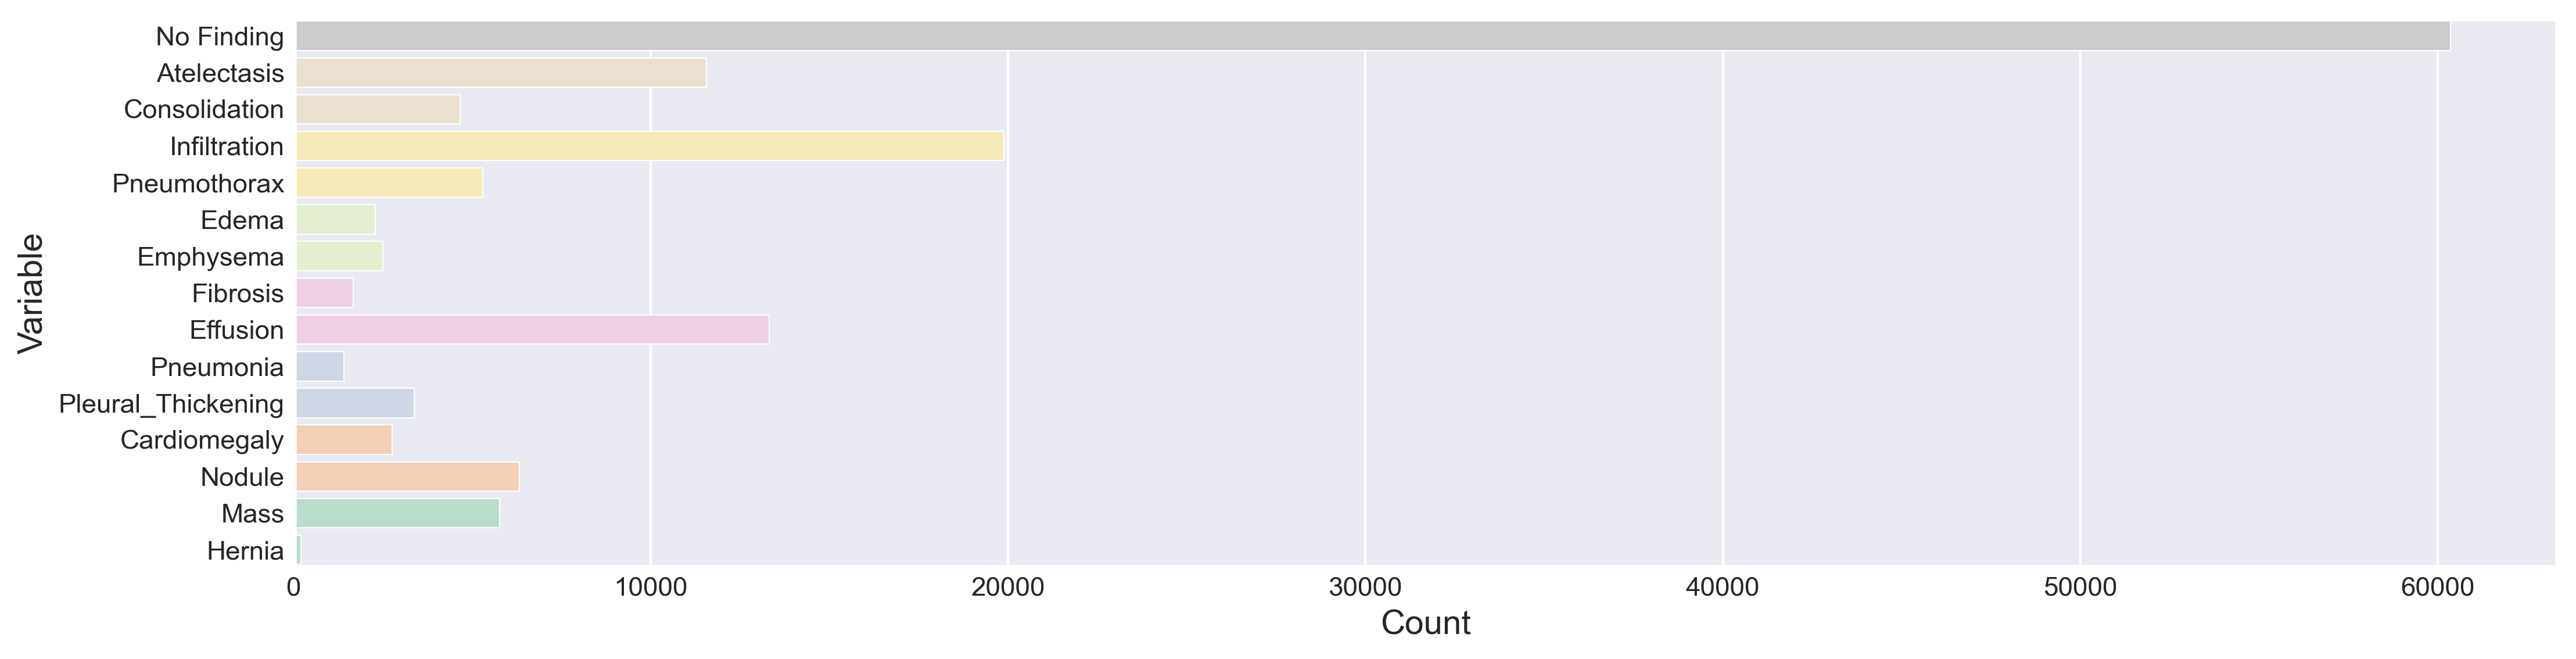

In [5]:
# create an empty list to hold all variables
l = []
# iterate each variable in the columns and append them to the list
for i in list(df.columns[:]):
    l.append(df[i].value_counts())

# generate a dataframe based on the list
sub_df = pd.concat(l, axis=1, keys=[s.name for s in l])

# generate a plot
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']}) 
sns.barplot(x=sub_df.iloc[0], y=sub_df.columns, orient = 'h', palette='Pastel2_r')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Variable', fontsize=14)
plt.tight_layout()

In [6]:
# iterate each column in sub_df and print out the count of each column for rows with TRUE value
for j in sub_df.columns:
    print('{}: {}'.format(j, sub_df[j].iloc[0]))

No Finding: 60361
Atelectasis: 11559
Consolidation: 4667
Infiltration: 19894
Pneumothorax: 5302
Edema: 2303
Emphysema: 2516
Fibrosis: 1686
Effusion: 13317
Pneumonia: 1431
Pleural_Thickening: 3385
Cardiomegaly: 2776
Nodule: 6331
Mass: 5782
Hernia: 227


We can see that this is an imbalanced dataset, in which we have 60,361 observations with no finding and 51,759 observations with findings. Let's take a deeper look at each variable. 

#### No Finding

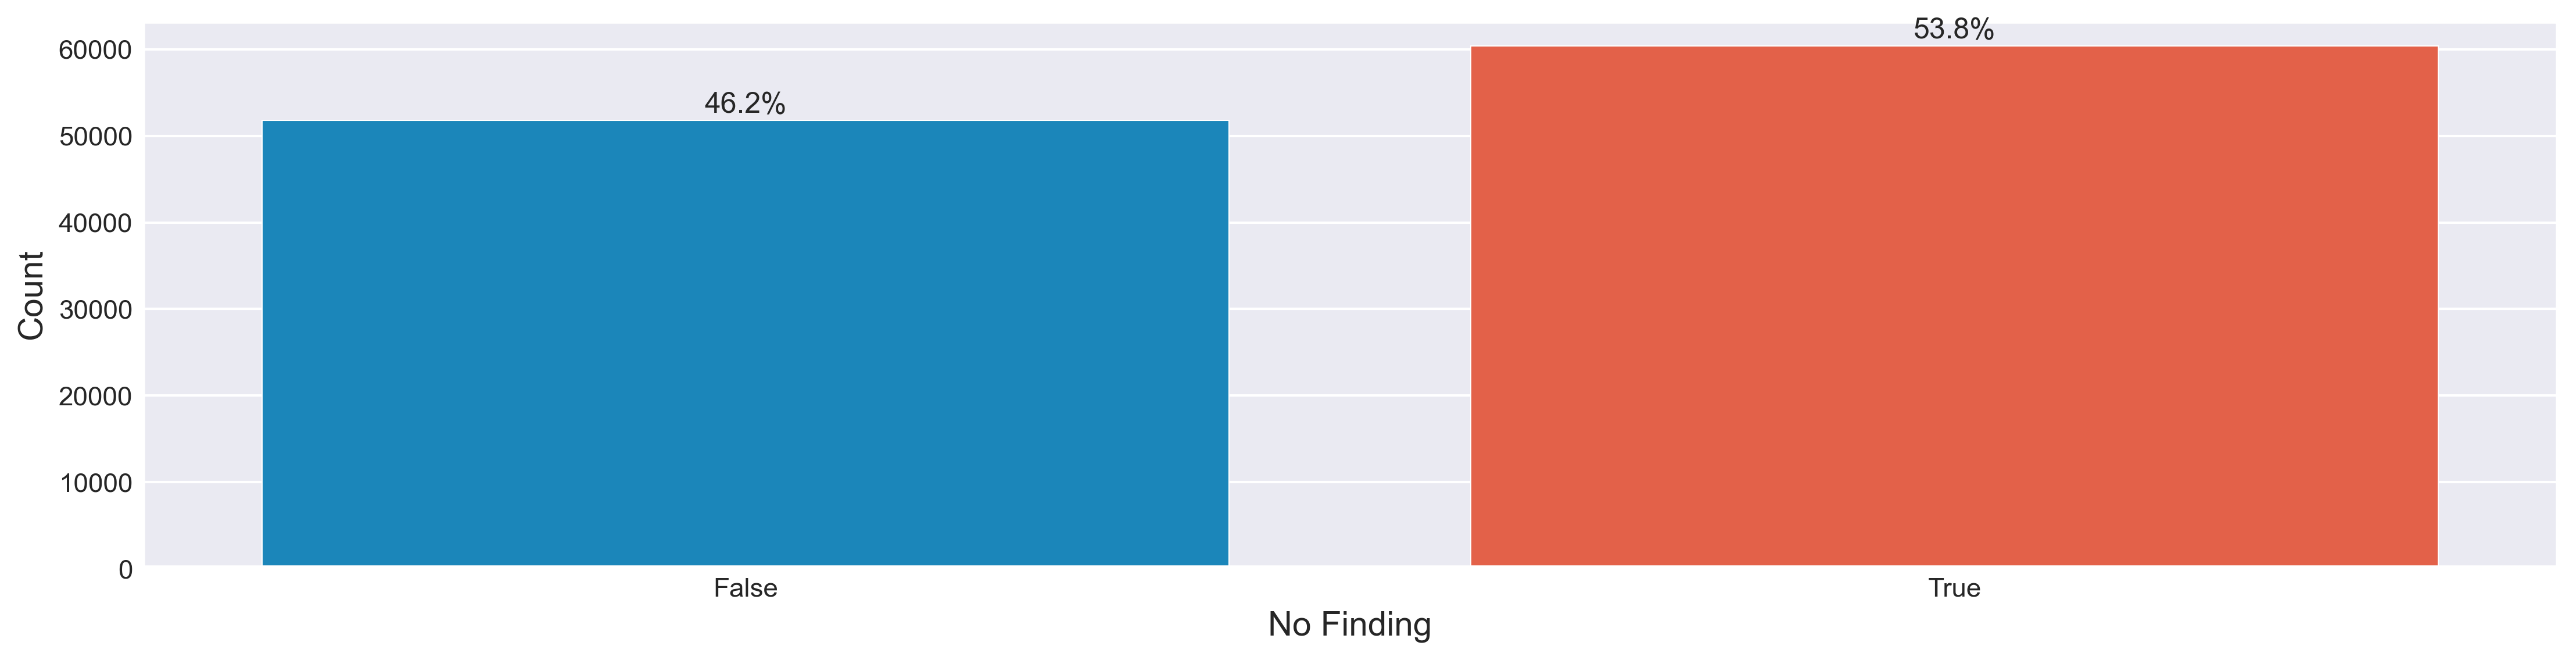

In [7]:
ax = sns.countplot(x='No Finding', data=df)
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
plt.xlabel('No Finding', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.tight_layout()

As mentioned above, we have an imbalanced dataset. 53.8% of observations are no finding and 46.2% of observations are other findings, which can be Atelectasis, Consolidation, Infiltration, Pneumothorax, Edema,  Emphysema, Fibrosis:, Effusion, Pneumonia, Pleural_Thickening, Cardiomegaly, Nodule, Mass, Hernia. Let's look at each finding below.

#### Other Findings

In [8]:
def countplot(features, data, total_cols):
    num_plots = len(features)
    total_rows = num_plots // total_cols + 1 
    fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols, 
                            figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
    row = 0
    pos = 0
    for i, var in enumerate(features):
        row = i // total_cols
        pos = i % total_cols
        plot = sns.countplot(x=var, data=data, ax=axs[row][pos])
        total = len(data)
        for p in plot.patches:
            percentage = f'{100 * p.get_height() / total:.1f}%\n'
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            plot.annotate(percentage,(x, y), ha='center', va='center', fontsize=15)
    
    for i in range(5):
        try:
            i += 1
            axs[row,pos+i].set_axis_off()
        except IndexError:
            pass

features = df.columns[1:]
countplot(features=features, data=df, total_cols=3)

* **Infiltration:** 17.7%
* **Effusion:** 11.9%
* **Atelectasis:** 10.3% 
* **Nodule:** 5.6%
* **Mass:** 5.2%
* **Pneumothorax:** 4.7%
* **Consolidation:** 4.2%
* **Pleural_Thickening:** 3.0%
* **Cardiomegaly:** 2.5%
* **Emphysema:** 2.2%
* **Edama:** 2.1%
* **Fibrosis:** 1.5%
* **Pneumonia:** 1.3%
* **Hernia:** 0.2%

To summarize, Infiltration has the most observations in the dataset for the findings as there are 17.7% of them, whereas Hernia has the least observations in the dataset since there are only 0.2% of them.

### TFRecords (Chest X-Rays)

Now, we will check out all the images saved in TFRecords. First, we will make a list of all the TFRecords.

In [9]:
# grabbing TFRecords
tfrlist = ['data/' + x for x in tfr_list]
filenames = tf.io.gfile.glob(tfrlist)

# first 5 samples
filenames[:5]

['data\\000-438.tfrec',
 'data\\001-438.tfrec',
 'data\\002-438.tfrec',
 'data\\003-438.tfrec',
 'data\\004-438.tfrec']

We define a function that helps us count the total images in the dataset.

In [10]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TOTAL_IMAGES = count_data_items(filenames)
print('Dataset: {} total images'.format(NUM_TOTAL_IMAGES))

Dataset: 112120 total images


We set up the parameters to pass them in some of the functions below.

In [11]:
# setting parameters
BATCH_SIZE = 64 # factor for the imbalanced dataset
IMAGE_ONE_AXIS = 200 # limit memory consumption per iteration 
IMAGE_SIZE = [IMAGE_ONE_AXIS, IMAGE_ONE_AXIS]
AUTOTUNE = tf.data.experimental.AUTOTUNE

# feature space for parsing
feature_description = {}
for elem in features:
    feature_description[elem] = tf.io.FixedLenFeature([], tf.int64)
    
feature_description['image'] = tf.io.FixedLenFeature([], tf.string)
feature_description

{'Atelectasis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Consolidation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Infiltration': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumothorax': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Edema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Emphysema': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Fibrosis': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Effusion': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pneumonia': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Pleural_Thickening': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Cardiomegaly': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Nodule': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'Mass': FixedLenFeature(shape=[], dtype=tf.int64, default_va

Now we will load in our data. For this notebook, we will be importing the TFRecord Files. The following three functions help us load the data in a random order.

In [12]:
def read_tfrecord(example):   # Function for reading the file
    '''
    This function uses the above defined feature description to decode the image and its label. 
    With the loop, I extract the feature's labels as a one-hot encoded list.
    No Findings would be a zero vector.
    '''
    example = tf.io.parse_single_example(example, feature_description)
    image = tf.io.decode_jpeg(example['image'], channels=3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    label = []
    for val in features: label.append(example[val])
    return image, label


def load_dataset(filenames):   # Loading the Data
    '''
    The TFRecordDataset weaves together the individiual TFRecords, essentially treating them as one dataset. 
    Randomness is introduced (deterministic = False) as no real order exists in the images. This speeds up loads.
    '''
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    return dataset


def get_dataset(filenames):   # Batch and shuffle
    '''
    This step takes the above loaded data, shuffles it with N=2048, 
    and defines the batch for feeding into the model.
    '''
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    return dataset


# Generating the data
'''
All the files now put into Batch objects. 
These objects can be fed directly into a CNN, without any further manipulation needed
'''
dataset = get_dataset(filenames)

Now, let's visualize 30 random samples.

In [13]:
# Visualising some random examples
image_viz, label_viz = next(iter(dataset))

def show_batch(X, Y):
    plt.figure(figsize=(30, 30))
    for n in range(30):
        ax = plt.subplot(6, 5, n + 1)
        plt.imshow(X[n])
        result = [x for i, x in enumerate(features) if Y[n][i]]
        title = ', '.join(result)
        if result == []: title = 'No Finding'
        plt.title(title)
        plt.axis('off')

show_batch(image_viz.numpy(), label_viz.numpy())

### Correlation

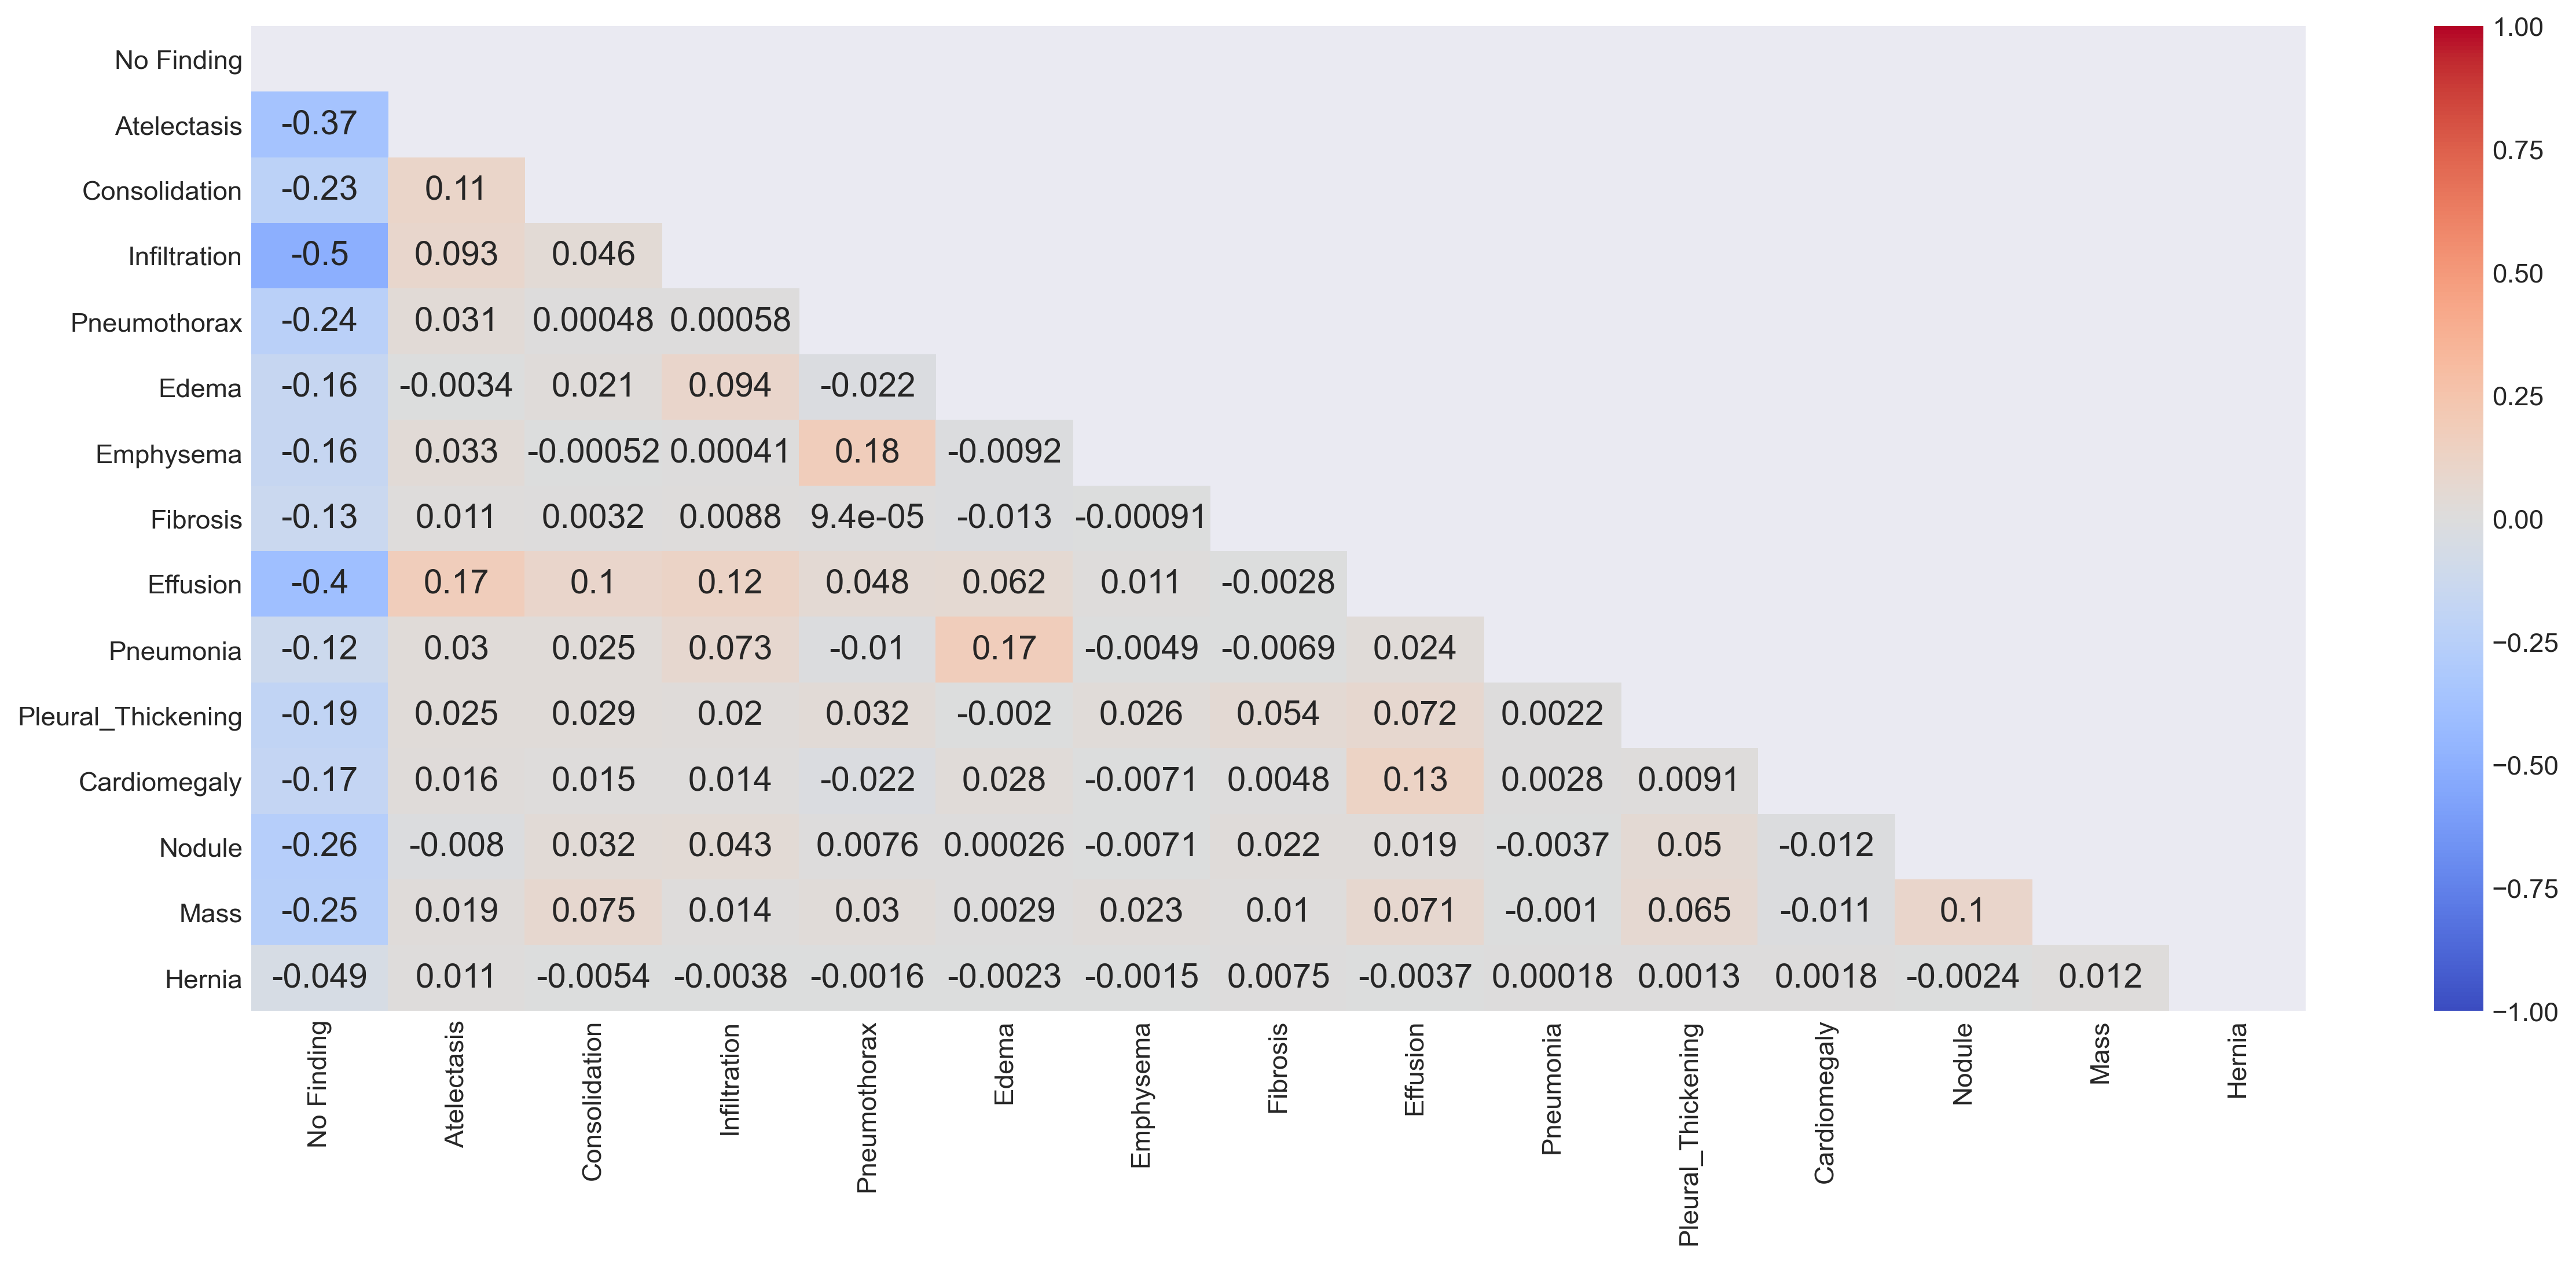

In [14]:
# triangle correlation heatmap
plt.figure(figsize=(17, 7))
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
heatmap = sns.heatmap(df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='coolwarm')

As shown in the heatmap, Emphysema and Pneumothorax have the strongest correlation in the dataset with a value of 0.18. The following two variables are Effusion and Atelectasis as their correlation coefficient is 0.17. Similarly, Pneumonia and Edema have 0.17 as their correlation coefficient. Thus, we should keep our eyes on the relationship between:
* *Emphysema and Pneumothorax*
* *Effusion and Atelectasis*
* *Pneumonia and Edema*

Based on their correlation coefficient, we can assume that a patient who has one disease is more likely to have other as well. For instance, if a person who has Emphysema, he/she may also have Pneumothorax. 